In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra
import ProgressMeter

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1342


In [2]:
# The following coefficients correspond to stable poles
coefs_ar_1 = [-0.27002517200218096]
coefs_ar_2 = [0.4511170798064709, -0.05740081602446657]
coefs_ar_5 = [0.10699399235785655, -0.5237303489793305, 0.3068897071844715, -0.17232255282458891, 0.13323964347539288];

In [3]:
function generateAR(num::Int, coefs::Vector{Float64}; variance=1.0)
    order = length(coefs)
    inits = randn(order)
    data = Vector{Vector{Float64}}(undef, num+3*order)
    data[1] = inits
    for i in 2:num+3*order
        data[i] = insert!(data[i-1][1:end-1], 1, rand(Distributions.Normal(coefs'data[i-1], sqrt(variance[])), 1)[1])
    end
    data = data[1+3*order:end]
    return data
end

generateAR (generic function with 1 method)

In [20]:
@model [ default_factorisation = MeanField() ] function lar_model_multivariate(T::Type{ Multivariate }, n, order, c, stype)
    
    γ  ~ GammaShapeRate(1.0, 1.0) 
    θ  ~ MvNormalMeanPrecision(zeros(order), diageye(order))
    
    # We create a sequence of random variables for hidden states
    x   = randomvar(n)
    # As well a sequence of observartions
    y   = datavar(Float64, n)
    
    ct  = constvar(c)
    γ_y = constvar(1.0)
    
    # Prior for first state
    x0 ~ MvNormalMeanPrecision(zeros(order), diageye(order))
    
    x_prev = x0
    
    # AR process requires extra meta information
    meta = ARMeta(Multivariate, order, stype)
    
    for i in 1:n
        x[i] ~ AR(x_prev, θ, γ) where { q = q(y, x)q(γ)q(θ), meta = meta }
        y[i] ~ NormalMeanPrecision(dot(ct, x[i]), γ_y)
        x_prev = x[i]
    end
    
    return x, y, θ, γ
end

lar_model_multivariate (generic function with 2 methods)

In [21]:
@model [ default_factorisation = MeanField() ] function lar_model_univariate(T::Type{Univariate}, n, order, c, stype)
    
    γ  ~ GammaShapeRate(1.0, 1.0)
    θ  ~ NormalMeanPrecision(0.0, 1.0)
    
    # We create a sequence of random variables for hidden states
    x   = randomvar(n)
    # As well a sequence of observartions
    y   = datavar(Float64, n)
    
    ct  = constvar(c)
    γ_y = constvar(1.0)

    # Prior for first state
    x0 ~ NormalMeanPrecision(0.0, 1.0)
    
    x_prev = x0
    
    # AR process requires extra meta information
    meta = ARMeta(Univariate, order, stype)
    
    for i in 1:n
        x[i] ~ AR(x_prev, θ, γ) where { q = q(y, x)q(γ)q(θ), meta = meta }
        y[i] ~ NormalMeanPrecision(dot(c, x[i]), γ_y)
        x_prev = x[i]
    end
    
    return x, y, θ, γ
end

lar_model_univariate (generic function with 2 methods)

In [26]:
function init_marginals!(::Type{ Multivariate }, order, γ, θ)
    setmarginal!(γ, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(order), diageye(order)))
end

function init_marginals!(::Type{ Univariate }, order, γ, θ)
    setmarginal!(γ, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, NormalMeanPrecision(0.0, 1.0))
end

init_marginals! (generic function with 2 methods)

In [27]:
function inference(data, order, artype, stype, niter)
    
    # We build a full graph based on number of observatios
    n = length(data)
    
    # Depending on the order of AR process `c` is
    # either a number or a vector
    c = ReactiveMP.ar_unit(artype, order)
    
    model, (x, y, θ, γ) = lar_model(artype, n, order, c, stype)
    
    γ_buffer = nothing
    θ_buffer = nothing
    x_buffer = Vector{Marginal}(undef, n)
    
    fe = Vector{Float64}()
    
    γsub = subscribe!(getmarginal(γ), (mγ) -> γ_buffer = mγ)
    θsub = subscribe!(getmarginal(θ), (mθ) -> θ_buffer = mθ)
    xsub = subscribe!(getmarginals(x), (mx) -> copyto!(x_buffer, mx))
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), (f) -> push!(fe, f))
    
    init_marginals!(artype, order, γ, θ)
    
    for i in 1:niter
        update!(y, data)
    end
    
    unsubscribe!(γsub)
    unsubscribe!(θsub)
    unsubscribe!(xsub)
    unsubscribe!(fesub)
    
    return γ_buffer, θ_buffer, x_buffer, fe
end

inference (generic function with 1 method)

In [61]:
using Random
Random.seed!(42)
n = 100

coefs = coefs_ar_5 # coefs_ar_1, coefs_ar_2, coefs_ar_5
gen_ar_order = length(coefs)
data = generateAR(n, coefs)
hidden_states =  first.(data)
observations = hidden_states .+ randn(length(hidden_states));

In [62]:
# 200 ms 113.70MiB
# 820 ms 517.17 MiB

In [158]:
# Univariate AR MASTER
ar_order = 1
γ, θ, xs, fe = inference(observations, ar_order, Univariate, ARsafe(), 100);

@show last(fe)

@benchmark inference($observations, $ar_order, Univariate, ARsafe(), 100)

last(fe) = 195.92059505068525


BenchmarkTools.Trial: 34 samples with 1 evaluation.
 Range (min … max):  142.005 ms … 164.138 ms  ┊ GC (min … max): 12.40% … 11.31%
 Time  (median):     147.234 ms               ┊ GC (median):    11.73%
 Time  (mean ± σ):   149.028 ms ±   5.760 ms  ┊ GC (mean ± σ):  12.57% ±  2.51%

  ▃    ▃   ▃▃█ ▃ ▃▃     ▃                                        
  █▁▁▇▁█▇▇▁███▇█▇██▇▁▁▁▁█▁▇▁▇▁▁▁▁▇▇▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▇▁▁▇▁▁▇ ▁
  142 ms           Histogram: frequency by time          164 ms <

 Memory estimate: 107.75 MiB, allocs estimate: 1692136.

In [160]:
# Univariate AR BRANCH
ar_order = 1
γ, θ, xs, fe = inference(observations, ar_order, Univariate, ARsafe(), 100);

@show last(fe)

@benchmark inference($observations, $ar_order, Univariate, ARsafe(), 100)

last(fe) = 195.92059505068525


BenchmarkTools.Trial: 38 samples with 1 evaluation.
 Range (min … max):  114.964 ms … 144.380 ms  ┊ GC (min … max):  0.00% … 12.31%
 Time  (median):     132.989 ms               ┊ GC (median):    12.44%
 Time  (mean ± σ):   133.747 ms ±   5.405 ms  ┊ GC (mean ± σ):  11.84% ±  2.84%

                                   ▂ ▂ █ ▂                       
  ▅▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███▅███▁█▁██▅▅▁█▁▅▁█▅▅▁▁▁▁▁▁▅▅ ▁
  115 ms           Histogram: frequency by time          144 ms <

 Memory estimate: 95.39 MiB, allocs estimate: 1582136.

In [159]:
# Multivariate AR MASTER
ar_order = gen_ar_order
γ, θ, xs, fe = inference(observations, ar_order, Multivariate, ARsafe(), 100);

@show last(fe)

@benchmark inference($observations, $ar_order, Multivariate, ARsafe(), 100)

last(fe) = 198.73666617687047


BenchmarkTools.Trial: 4 samples with 1 evaluation.
 Range (min … max):  1.426 s …   1.512 s  ┊ GC (min … max): 10.16% … 9.10%
 Time  (median):     1.467 s              ┊ GC (median):    10.07%
 Time  (mean ± σ):   1.468 s ± 39.997 ms  ┊ GC (mean ± σ):  10.03% ± 0.70%

  █          █                              █             █  
  █▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.43 s         Histogram: frequency by time        1.51 s <

 Memory estimate: 1011.30 MiB, allocs estimate: 6059980.

In [161]:
# Multivariate AR Branch
ar_order = gen_ar_order
γ, θ, xs, fe = inference(observations, ar_order, Multivariate, ARsafe(), 100);

@show last(fe)

@benchmark inference($observations, $ar_order, Multivariate, ARsafe(), 100)

last(fe) = 198.73666617687047


BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  837.405 ms … 948.178 ms  ┊ GC (min … max):  9.85% … 9.55%
 Time  (median):     905.578 ms               ┊ GC (median):    10.28%
 Time  (mean ± σ):   893.863 ms ±  45.020 ms  ┊ GC (mean ± σ):  10.33% ± 0.62%

  █ █                                 █ █         █           █  
  █▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█ ▁
  837 ms           Histogram: frequency by time          948 ms <

 Memory estimate: 599.50 MiB, allocs estimate: 4287871.

In [162]:
# Extract inferred parameters
mx, vx = mean.(xs), cov.(xs)
mx = first.(mx)
vx = first.(vx)
mθ = mean(θ)
vθ = cov(θ)
mγ = mean(γ);

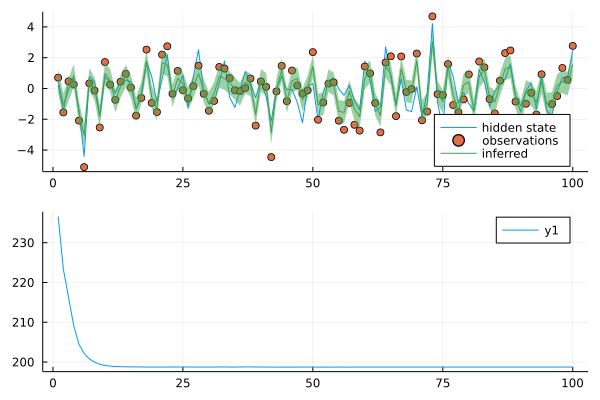

In [163]:
using Plots
p1 = plot(hidden_states, label="hidden state")
p1 = scatter!(p1, observations, label="observations")
p1 = plot!(p1, mx, ribbon = sqrt.(vx), label="inferred", legend=:bottomright)

p2 = plot(fe)

plot(p1, p2, layout = @layout([ a; b ]))

In [101]:
mθ

5-element Vector{Float64}:
  0.16722578415195494
 -0.4179749828986213
  0.4250950132316378
 -0.12991021793912289
  0.048847370225410025

In [102]:
coefs_ar_5

5-element Vector{Float64}:
  0.10699399235785655
 -0.5237303489793305
  0.3068897071844715
 -0.17232255282458891
  0.13323964347539288